### Summary
From Lecture: https://product-data-science.datamasked.com/courses/621233/lectures/11105795

### Steps
1. 了解題意: 確定hypothesis指的是什麼? 原先發現「母國說西班牙語的 conversion 優於非西班牙語國家的 conversion」
    * 所以做了 A/B testing，在「非西班牙的國家」用localized的語言 v.s. 「在非西班牙國家」用西班牙語
    * 發現negative: 「在非西班牙國家」用西班牙語的 conversion > 在「非西班牙的國家」用localized的語言的 conversion
    * null = 等於 在「非西班牙的國家」用localized的語言的 conversion > 「在非西班牙國家」用西班牙語的 conversion (negative 代表拒絕 null hypothesis)
    * test = 1 代表「非西班牙國家」用 localized 語言
2. 確認問題:
    * Q1: Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better
    * A1: 先看西班牙是否 conversion 高於其他國家? 確認做 t-test 的前提假設、再做一次 t-test 看是不是真的 negative?
    * Q2: Explain why that might be happening. Are the localized translations really worse?
    * A2: 做 EDA 去找一些 insights
    * Q3: If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.
3. 實作 A1
    * 先了解 data，看 data distribution, 是否是 imbalanced data, 是否能用 t-test 去做
    * 真正 apply t-test 去比對 Q1 結果
4. 實作 A2 - 做 EDA

### Questions
1. 到底要用哪種 t-test? null hypothesis 是什麼?


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 先驗證西班牙是否 conversion rate > 非西班牙的國家

In [2]:
# Read in data
test = pd.read_csv("/Users/eve/Desktop/Datasets/Translation_Test/test_table.csv")
test.head(2)

user_id        date  source device browser_language ads_channel browser  \
0   315281  2015-12-03  Direct    Web               ES         NaN      IE   
1   497851  2015-12-04     Ads    Web               ES      Google      IE   

   conversion  test  
0           1     0  
1           0     1

In [3]:
user = pd.read_csv("/Users/eve/Desktop/Datasets/Translation_Test/user_table.csv")
user.head(2)

user_id sex  age    country
0   765821   M   20     Mexico
1   343561   F   27  Nicaragua

In [4]:
print("Length of test table: {}, Length of user table: {}".format(len(test), len(user)))

Length of test table: 453321, Length of user table: 452867


In [5]:
# Merge two tables
df = test.merge(user, on = 'user_id')
print("Length of merged data: {}".format(len(df)))
df.head(2)

Length of merged data: 452867


user_id        date  source device browser_language ads_channel browser  \
0   315281  2015-12-03  Direct    Web               ES         NaN      IE   
1   497851  2015-12-04     Ads    Web               ES      Google      IE   

   conversion  test sex  age country  
0           1     0   M   32   Spain  
1           0     1   M   21  Mexico

In [6]:
df[df["test"] == 0].groupby(["country"])["conversion"].agg({"count", "mean"}).reset_index().sort_values("mean", ascending = False)

country      mean  count
14        Spain  0.079719  51782
6   El Salvador  0.053554   4108
10    Nicaragua  0.052647   3419
4    Costa Rica  0.052256   2660
3      Colombia  0.052089  27088
8      Honduras  0.050906   4361
7     Guatemala  0.050643   7622
16    Venezuela  0.050344  16149
13         Peru  0.049914  16869
9        Mexico  0.049495  64209
1       Bolivia  0.049369   5550
5       Ecuador  0.049154   8036
12     Paraguay  0.048493   3650
2         Chile  0.048107   9853
11       Panama  0.046796   1966
0     Argentina  0.015071   9356
15      Uruguay  0.012048    415

### 進入 A/B testing 階段
1. 重現原本的 t-test，比較 localized v.s. non-localized 的 conversion rate
2. 深入 deep dive 原因

In [7]:
# 為了要重現 t-test，去掉 Spain，因為 Spain 並沒有變化 (i.e. in treatment group)
data = df[df["country"] != "Spain"]

# 確認用哪種 t-test? (equal variation v.s. unequal variation)
def sample_variance(x):
    return np.std(x, ddof = 1)

data.groupby(["test"])["conversion"].agg({"count", sample_variance}).reset_index()

# # Different way
# df.groupby(["test"]).agg(np.std, ddof = 1)

# # or
# np.sqrt(pd.Series(df[df["test"] == 0]["conversion"]).var(ddof = 1))
# np.sqrt(pd.Series(df[df["test"] == 1]["conversion"]).var(ddof = 1))

test   count  sample_variance
0     0  185311         0.214383
1     1  215774         0.203781

In [8]:
# 確認用 t-test unequal variance 
from scipy import stats
t, p = stats.ttest_ind(data[data["test"] == 1]["conversion"],
                      data[data["test"] == 0]["conversion"],
                      equal_var= False)
print("Critical value = {}, P-value = {}".format(t, p))

Critical value = -7.353895203080277, P-value = 1.9289178577799033e-13


### Deep Dive Root Causes

In [9]:
# 看到「用 non-localized 的非西班牙國家 conversion rate 較高」
data.groupby(["test"])["conversion"].agg({"count", "mean"}).reset_index().sort_values("mean", ascending = False)

test      mean   count
0     0  0.048292  185311
1     1  0.043411  215774

#### Possible root cause I - data not enough
1. 用 sample size 角度來看

In [10]:
data["date"] = pd.to_datetime(data["date"])
bydate = data.groupby(["date", "test"]).size().reset_index()
bydate

/Users/eve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


date  test      0
0 2015-11-30     0  28982
1 2015-11-30     1  33844
2 2015-12-01     0  28995
3 2015-12-01     1  33840
4 2015-12-02     0  28903
5 2015-12-02     1  33517
6 2015-12-03     0  40727
7 2015-12-03     1  47383
8 2015-12-04     0  57704
9 2015-12-04     1  67190

In [11]:
# 因為上面的表沒有分出 test == 0 or test == 1，所以另外做個圖
control = bydate[bydate["test"]==0].rename(columns = {0:"control"}).drop("test", axis = 1)
treatment = bydate[bydate["test"]==1].rename(columns = {0:"treatment"}).drop("test", axis = 1)
new = control.merge(treatment, on = "date")
new

date  control  treatment
0 2015-11-30    28982      33844
1 2015-12-01    28995      33840
2 2015-12-02    28903      33517
3 2015-12-03    40727      47383
4 2015-12-04    57704      67190

In [12]:
new.set_index("date", inplace = True)
new

control  treatment
date                          
2015-11-30    28982      33844
2015-12-01    28995      33840
2015-12-02    28903      33517
2015-12-03    40727      47383
2015-12-04    57704      67190

Text(0, 0.5, 'Number of counts')

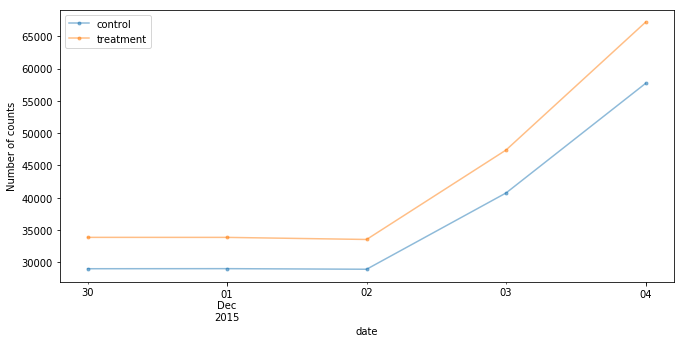

In [13]:
new[["control", "treatment"]].plot(marker = ".", alpha = 0.5, figsize = (11, 5)).set_ylabel("Number of counts")

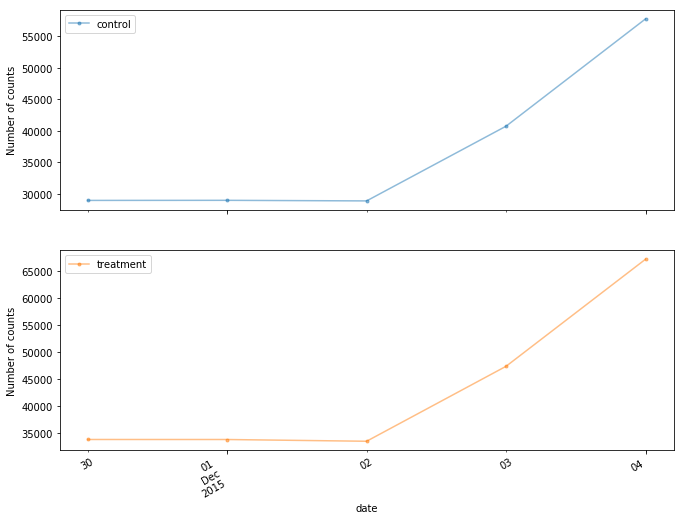

In [14]:
# 顯示兩個 subplots
axes = new[["control", "treatment"]].plot(marker = '.', alpha = 0.5, figsize = (11, 9), subplots = True)
for ax in axes:
    ax.set_ylabel("Number of counts")

#### 用 conversion rate by date 角度來看

In [15]:
data.groupby(["date"])["conversion"].agg({"test_vs_control": lambda x : x[data["test"] == 1].mean() / x[data["test"] == 0].mean()})

/Users/eve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


test_vs_control
date                       
2015-11-30         0.856918
2015-12-01         0.894524
2015-12-02         0.912195
2015-12-03         0.891235
2015-12-04         0.922985

/Users/eve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Test v.s. Control Ratio')

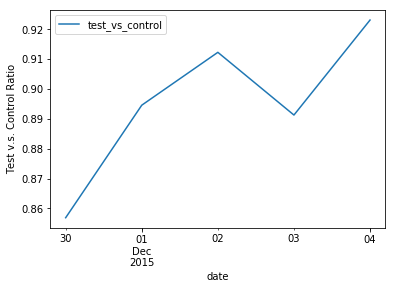

In [16]:
data.groupby(["date"])["conversion"].agg({"test_vs_control": lambda x : x[data["test"] == 1].mean() / x[data["test"] == 0].mean()}).plot().set_ylabel("Test v.s. Control Ratio")

In [17]:
# 同上面的一行 groupby 解
new = data.groupby(["date", "test"])["conversion"].mean().reset_index()
new

date  test  conversion
0 2015-11-30     0    0.051204
1 2015-11-30     1    0.043878
2 2015-12-01     0    0.046249
3 2015-12-01     1    0.041371
4 2015-12-02     0    0.048472
5 2015-12-02     1    0.044216
6 2015-12-03     0    0.049255
7 2015-12-03     1    0.043898
8 2015-12-04     0    0.047085
9 2015-12-04     1    0.043459

In [18]:
treatment = new[new["test"] == 1].rename(columns = {"conversion" : "conversion_treatment"}).drop("test", axis = 1)
control = new[new["test"] == 0].rename(columns = {"conversion" : "conversion_control"}).drop("test", axis = 1)
new2 = control.merge(treatment, on = "date")
new2["ratio"] = round(new2["conversion_treatment"] / new2["conversion_control"], 2)
new2

date  conversion_control  conversion_treatment  ratio
0 2015-11-30            0.051204              0.043878   0.86
1 2015-12-01            0.046249              0.041371   0.89
2 2015-12-02            0.048472              0.044216   0.91
3 2015-12-03            0.049255              0.043898   0.89
4 2015-12-04            0.047085              0.043459   0.92

Text(0, 0.5, 'Treatment v.s. Control Ratio')

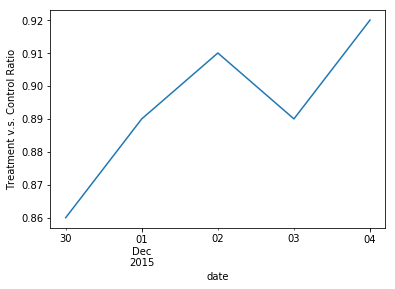

In [19]:
new2.set_index("date", inplace = True)
new2["ratio"].plot().set_ylabel("Treatment v.s. Control Ratio")

### Possible Root Cause II - Sampling Bias
1. 有些 variables 在 test/control 裡的數量不一致 (i.e. A/B Test Randomization)
2. 注意，這裡跟 conversion 已經無關，我們在意的是「每個 variable 內 test/control 的 sample distribution 是否一致」
3. 例如 source 中，是 (Ads 且 test == 0)/test == 0 比例跟 (是Ads 且 test == 1)/ test == 1 比例是否類似?

In [20]:
# source
d = data.groupby(["source", "test"])["test"].agg({"count"}).reset_index()
d

source  test  count
0     Ads     0  74352
1     Ads     1  86448
2  Direct     0  37238
3  Direct     1  43047
4     SEO     0  73721
5     SEO     1  86279

In [21]:
control = data.groupby(["source"])["test"].agg({'control':lambda x : len(x[x == 0])})
control / control.sum()

/Users/eve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


control
source          
Ads     0.401228
Direct  0.200949
SEO     0.397823

In [22]:
treatment = data.groupby(["source"])["test"].agg({'treatment':lambda x: len(x[x == 1])})
treatment / treatment.sum()

/Users/eve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


treatment
source           
Ads      0.400641
Direct   0.199500
SEO      0.399858

#### 用同樣的 groupby 方式太費時，用 decision tree 去看 randomness


In [34]:
# 1. Manipulate data to prepare for modeling
data['date'] = data['date'].apply(str)
data_dummy = pd.get_dummies(data)

train_cols = data_dummy.drop(["test", "conversion"], axis = 1)

/Users/eve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
# 2. Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

clt = DecisionTreeClassifier(class_weight = "balanced", min_impurity_decrease = 0.001)
clt.fit(train_cols, data_dummy["test"])

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [36]:
# 3. Draw decision tree plot
export_graphviz(clt, out_file = "tree.dot", feature_names=train_cols.columns, proportion = True)
s = graphviz.Source.from_file("tree.dot")
s.view()

'tree.dot.pdf'

### 解讀
1. 從上面 decision tree 得知，在 country 的 random sampling has sampling bias，因此造成原本 A/B testing 做完後所發現的 insight (i.e. non-localized's conversion > localized's conversion) 不是那麼一回事，代表localized的表現並沒有以為的那麼差。

In [48]:
remove = data[(data["country"] != "Argentina") & (data["country"] != "Uruguay")]

t, p = stats.ttest_ind(remove[remove["test"] == 1]["conversion"], 
                       remove[remove["test"] == 0]["conversion"],
                       equal_var = False)
print("T-statistics = {} and P-value = {}".format(t, p))

In [51]:
print(data_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean())

      country_Argentina  country_Uruguay
test                                    
0              0.050488         0.002239
1              0.173223         0.017236


In [54]:
original_data = stats.ttest_ind(data[data['test'] == 1]['conversion'], 
                                data[data['test'] == 0]['conversion'], 
                                equal_var=False)
original_data

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)

In [56]:
data_no_AR_UR = stats.ttest_ind(data_dummy[(data['test'] == 1) & 
                                           (data['country'] != 'Argentina') & 
                                           (data['country'] !=  'Uruguay')
                                           ]['conversion'], 
                                data_dummy[(data['test'] == 0) & 
                                           (data['country'] != 'Argentina') & 
                                           (data['country'] !=  'Uruguay')
                                           ]['conversion'], 
                                equal_var=False)
data_no_AR_UR

Ttest_indResult(statistic=0.3583455794481446, pvalue=0.7200849282884506)

In [57]:
remove = data[(data["country"] != "Argentina") & (data["country"] != "Uruguay")]

t, p = stats.ttest_ind(remove[remove["test"] == 1]["conversion"], 
                       remove[remove["test"] == 0]["conversion"],
                       equal_var = False)
print("T-statistics = {} and P-value = {}".format(t, p))

T-statistics = 0.3583455794481446 and P-value = 0.7200849282884506


In [40]:
data.groupby(["country"])["conversion"].agg({
    "p_value" : lambda x : stats.ttest_ind(x[data["test"] == 1],
                                          x[data["test"] == 0],
                                          equal_var = False).pvalue,
    "conversion_treatment" : lambda x : x[data["test"] == 1].mean(),
    "conversion_control" : lambda x : x[data["test"] == 0].mean()
}).reset_index().sort_values("p_value", ascending = True)

/Users/eve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


country   p_value  conversion_treatment  conversion_control
9        Mexico  0.165544              0.051186            0.049495
6   El Salvador  0.248127              0.047947            0.053554
2         Chile  0.302848              0.051295            0.048107
0     Argentina  0.335147              0.013725            0.015071
3      Colombia  0.423719              0.050571            0.052089
8      Honduras  0.471463              0.047540            0.050906
7     Guatemala  0.572107              0.048647            0.050643
15    Venezuela  0.573702              0.048978            0.050344
4    Costa Rica  0.687876              0.054738            0.052256
11       Panama  0.705327              0.049370            0.046796
1       Bolivia  0.718885              0.047901            0.049369
13         Peru  0.771953              0.050604            0.049914
10    Nicaragua  0.780400              0.054177            0.052647
14      Uruguay  0.879764              0.012907            0.012048
12     Paraguay  0.883697              0.049229            0.048493
5       Ecuador  0.961512              0.048988            0.049154